In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
#from SmoothShap import verify_shap_model, smooth_shap

In [196]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
from imodels import HSTreeClassifier, HSTreeRegressor, HSTreeClassifierCV, HSTreeRegressorCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
#import shap
#from shap.explainers._tree import SingleTree
from tqdm import tqdm
import pickle
from datetime import datetime

In [207]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","hs_BiasVarTradeoff_simulation")
today_str = datetime.today().strftime("%Y%m%d")

In [111]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = True

# Recreation of results from hierarchical shrinkage paper

Hierarchical Shrinkage: Improving the accuracy and interpretability of tree-based models <br>
[Link to paper](https://proceedings.mlr.press/v162/agarwal22b.html)


>HS is integrated into the imodels package [imodels](github.com/csinva/imodels) (Singh et al., 2021) with an sklearn compatible API. Experiments for reproducing the results here can be found at [imodels-experiments](github.com/Yu-Group/imodels-experiments)

Unfortunately, not all experiments/ figures of the paper can be found in the aforementioned GitHub repository, therefore some of the charts will not be identical to the paper.

## Simulations for Investigating the Bias-Variance Trade-off (Fig. S1 & S2)

### Define function to create simulation and run experiment

In [167]:
# M = 100
# n_samples = 500
# n_feats = 50
# idx_imp_feat = 10
# vals_lambda = np.arange(45.,101.,5.)
# vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140]# 200, 300, 400, 500]

In [219]:
def bias_var_lin_simulation(M=100, n_samples=500, n_feats=50, idx_imp_feat=10, vals_lambda = np.arange(45.,101.,5.), vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140], noise="gaussian", interaction=False):

    # Create training data
    X_train = np.random.uniform(0, 1, size=(M, n_samples, n_feats))
    if noise=="gaussian":
        noise = np.random.normal(loc=0., scale=0.1, size=(M, n_samples,))
    else:
        noise = np.random.laplace(loc=0., scale=0.1, size=(M, n_samples,))
        
    if interaction == False:
        y_train = X_train[:,:,:idx_imp_feat].sum(axis=2) + noise
    else:
       y_train = X_train[:,:,:idx_imp_feat].sum(axis=2) + X_train[:,:,0]*X_train[:,:,1] + X_train[:,:,4]*X_train[:,:,5] + X_train[:,:,10]*X_train[:,:,11] + noise

    # Create test data
    X_test = np.random.uniform(0, 1, size=(n_samples, n_feats))
    if interaction == False:
        y_test = X_test[:,:idx_imp_feat].sum(axis=1)
    else:
        y_test = X_test[:,:idx_imp_feat].sum(axis=1) + X_test[:,0]*X_test[:,1] + X_test[:,4]*X_test[:,5] + X_test[:,10]*X_test[:,11]

    #Store results
    y_preds= np.empty((M, len(vals_n_leaves), n_samples))
    y_preds_HS = np.empty((M, len(vals_n_leaves), n_samples))
    y_preds_train= np.empty((M, len(vals_n_leaves), n_samples))
    y_preds_train_HS = np.empty((M, len(vals_n_leaves), n_samples))
    lambdas = np.empty((M, len(vals_n_leaves)))
    bias_squared = np.empty((M, len(vals_n_leaves)))
    bias_squaredHS = np.empty((M, len(vals_n_leaves)))
    mse_scores = np.empty((M, len(vals_n_leaves)))
    mse_scoresHS = np.empty((M, len(vals_n_leaves)))

    for i in tqdm(range(M)):

        for j, n_leaves in enumerate(vals_n_leaves):
            reg_tree_sk = DecisionTreeRegressor(max_leaf_nodes=n_leaves)
            reg_tree_sk.fit(X_train[i,:,:], y_train[i,:])
            y_preds[i,j,:] = reg_tree_sk.predict(X_test)
            y_preds_train[i,j,:] = reg_tree_sk.predict(X_train[i,:,:])

            bias_squared[i,j] = ((y_preds_train[i,j,:] - y_train[i,:])**2).mean()
            mse_scores[i,j] = mean_squared_error(y_test, y_preds[i,j,:])

            reg_tree_im = HSTreeRegressorCV(deepcopy(reg_tree_sk), reg_param_list=vals_lambda, cv=3, scoring="neg_mean_squared_error")
            reg_tree_im.fit(X_train[i,:,:], y_train[i,:])
            y_preds_HS[i,j,:] = reg_tree_im.predict(X_test)
            y_preds_train_HS[i,j,:] = reg_tree_im.predict(X_train[i,:,:])

            lambdas[i,j] = reg_tree_im.reg_param

            bias_squaredHS[i,j] = ((y_preds_train_HS[i,j,:] - y_train[i,:])**2).mean()
            mse_scoresHS[i,j] = mean_squared_error(y_test, y_preds_HS[i,j,:])

    return {"X_train":X_train, 
            "y_train":y_train, 
            "X_test":X_test, 
            "y_test":y_test, 
            "y_preds_train":y_preds_train, 
            "y_preds_train_HS":y_preds_train_HS, 
            "y_preds": y_preds, 
            "y_preds_HS": y_preds_HS, 
            "lambdas": lambdas, 
            "bias_squared":bias_squared, 
            "bias_squaredHS":bias_squaredHS, 
            "mse_scores":mse_scores, 
            "mse_scoresHS":mse_scoresHS}

### Figure S1 (linear model)

In [195]:
gaus_sim_result_dict = bias_var_lin_simulation(noise="gaussian", interaction=False)

100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


In [ ]:
with open(f'{data_path}/{today_str}_gaus_linmodel.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [208]:
#Laplace
lap_sim_result_dict = bias_var_lin_simulation(noise="laplace", interaction=False)

100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


In [209]:
with open(f'{data_path}/{today_str}_lap_linmodel.pickle', 'wb') as handle:
    pickle.dump(lap_sim_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

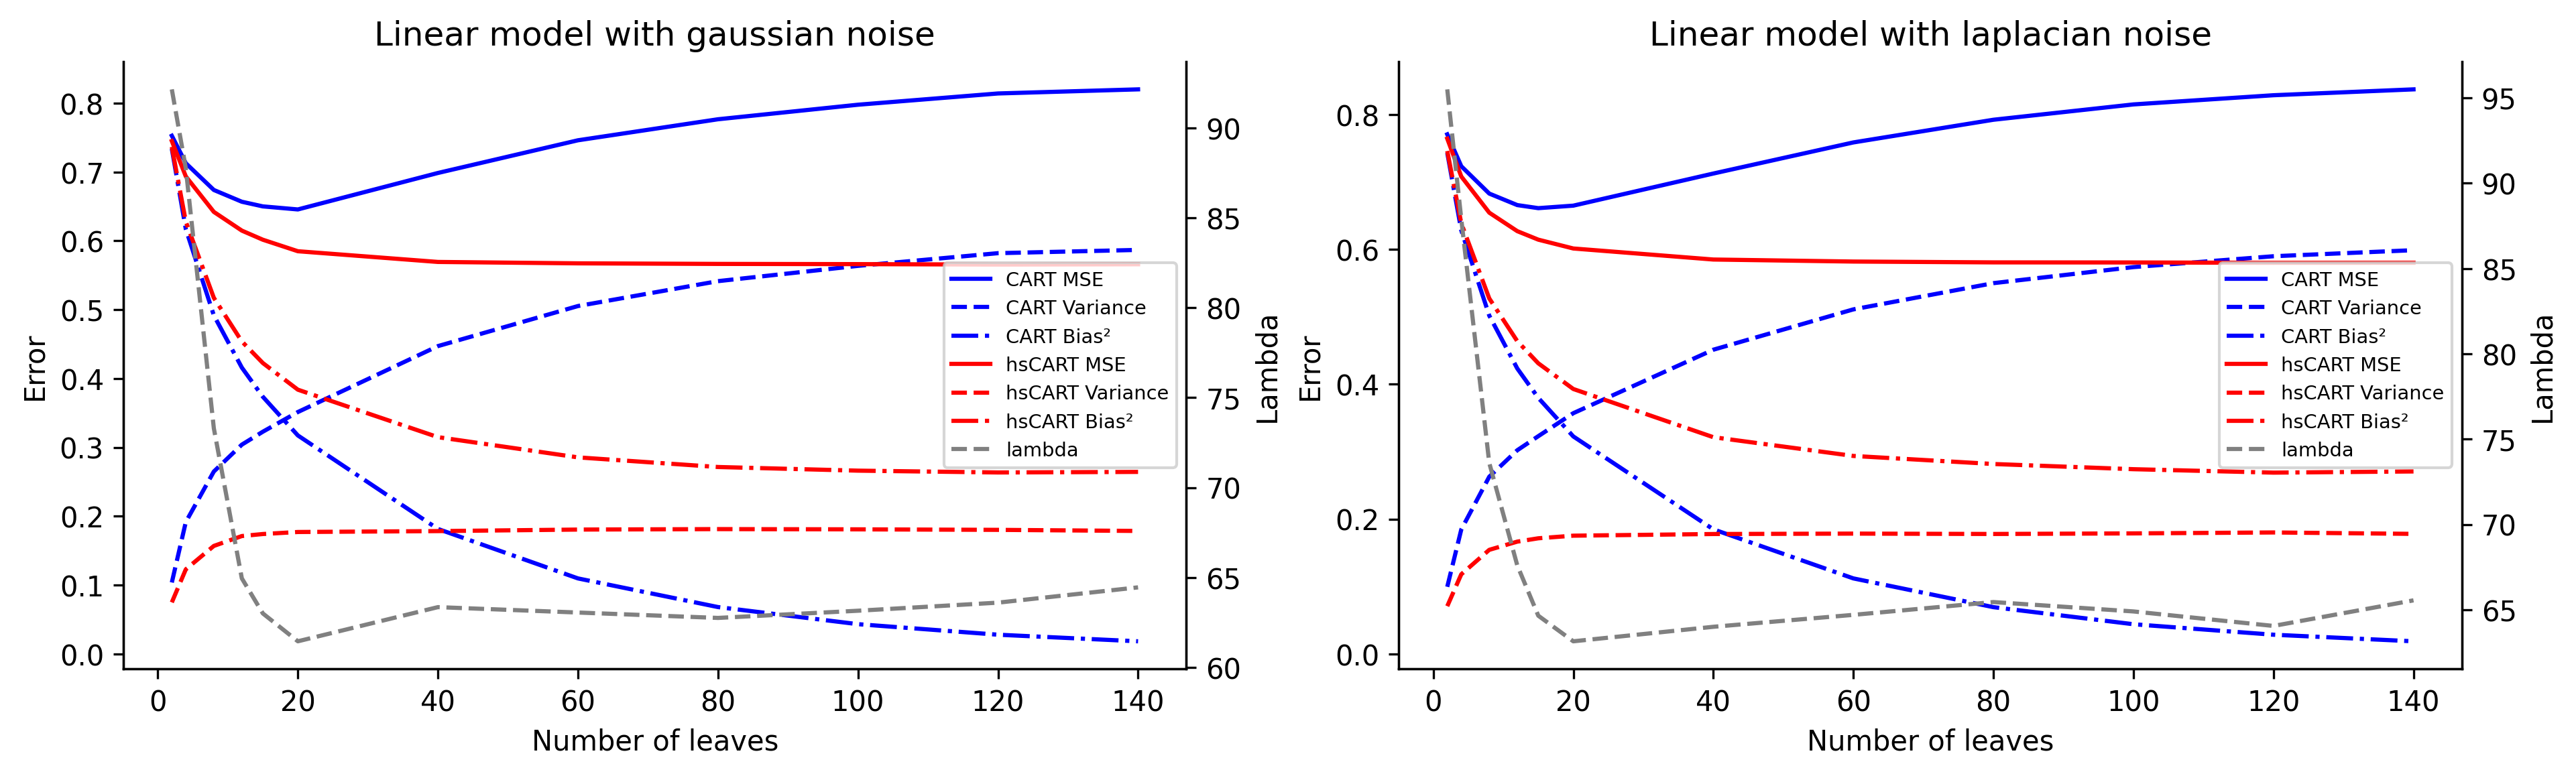

In [214]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140]

#Plot Gaussian
lns1 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_n_leaves, gaus_sim_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_n_leaves, gaus_sim_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Number of leaves")

ax[0].set_title("Linear model with gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_n_leaves, lap_sim_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_n_leaves, lap_sim_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Number of leaves")

ax[1].set_title("Linear model with laplacian noise");

### Figure S2 (linear model with pairwise interaction)

In [220]:
gaus_sim_inter_result_dict = bias_var_lin_simulation(noise="gaussian", interaction=True)

100%|██████████| 100/100 [09:37<00:00,  5.78s/it]


In [221]:
with open(f'{data_path}/{today_str}_gaus_linmodel_interaction.pickle', 'wb') as handle:
    pickle.dump(gaus_sim_inter_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [222]:
#Laplace
lap_sim_inter_result_dict = bias_var_lin_simulation(noise="laplace", interaction=True)

100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


In [223]:
with open(f'{data_path}/{today_str}_lap_linmodel_interaction.pickle', 'wb') as handle:
    pickle.dump(lap_sim_inter_result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

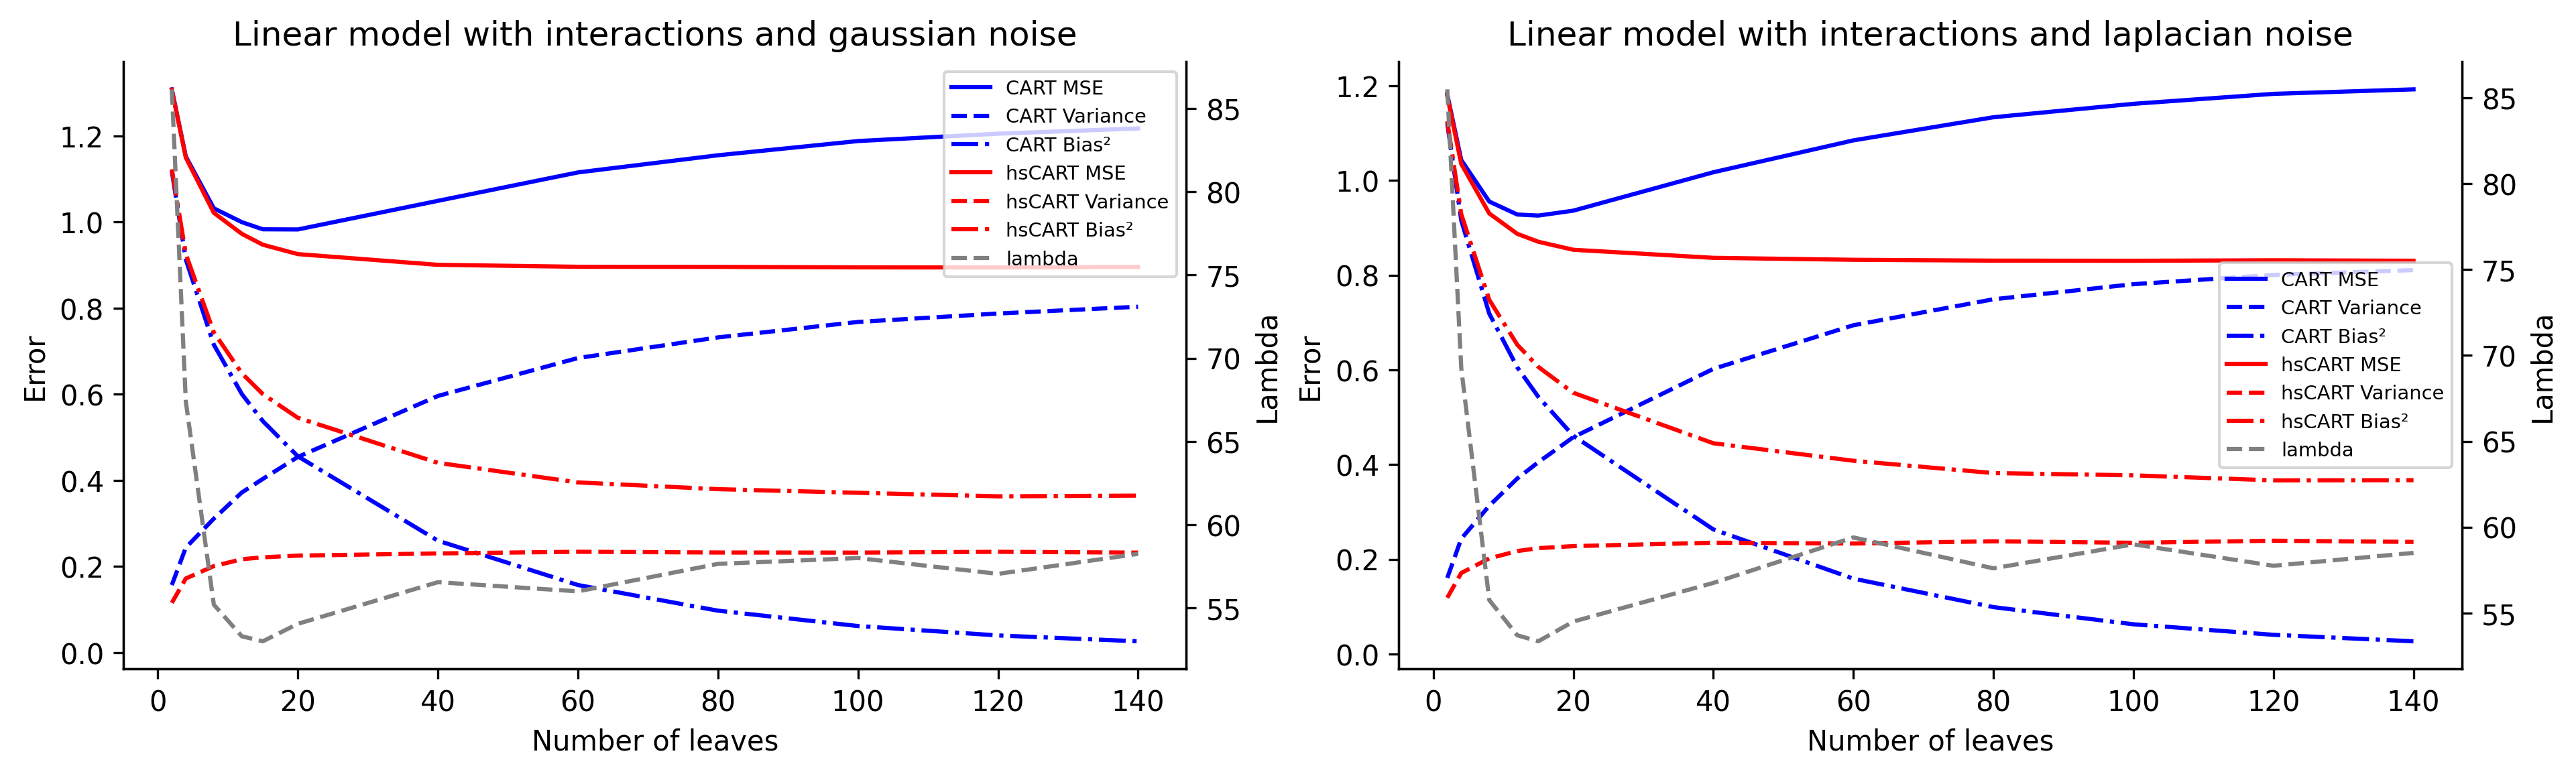

In [224]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

vals_n_leaves = [2, 4, 8, 12, 15, 20, 40, 60, 80, 100, 120, 140]

#Plot Gaussian
lns1 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns2 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns3 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns4 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns5 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns6 = ax[0].plot(vals_n_leaves, gaus_sim_inter_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax2=ax[0].twinx()
lns7 = ax2.plot(vals_n_leaves, gaus_sim_inter_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[0].set_ylabel("Error")
ax2.set_ylabel("Lambda")

# Create common legend for both y-axis 
lns = lns1+lns2+lns3+lns4+lns5+lns6+lns7
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0, fontsize='x-small')
ax[0].set_xlabel("Number of leaves")

ax[0].set_title("Linear model with interactions and gaussian noise")

# #Plot Laplace
lns11 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["mse_scores"].mean(axis=0), color="b", label="CART MSE")
lns21 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["y_preds"].var(axis=0).mean(axis=1), color="b", linestyle="--", label="CART Variance")
lns31 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["bias_squared"].mean(axis=0), color="b", linestyle="-.", label="CART Bias²")
lns41 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["mse_scoresHS"].mean(axis=0), color="r", label="hsCART MSE")
lns51 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["y_preds_HS"].var(axis=0).mean(axis=1), color="r", linestyle="--", label="hsCART Variance")
lns61 = ax[1].plot(vals_n_leaves, lap_sim_inter_result_dict["bias_squaredHS"].mean(axis=0), color="r", linestyle="-.", label="hsCART Bias²")

ax21=ax[1].twinx()
lns71 = ax21.plot(vals_n_leaves, lap_sim_inter_result_dict["lambdas"].mean(axis=0), color="grey", linestyle="--", label="lambda")

ax[1].set_ylabel("Error")
ax21.set_ylabel("Lambda")

# Create common legend for both y-axis 
ax[1].legend(lns, labs, loc=0, fontsize='x-small')
ax[1].set_xlabel("Number of leaves")

ax[1].set_title("Linear model with interactions and laplacian noise");